In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc

import torch
# font manager
# add font by otf file
from matplotlib import font_manager as fm
# fm.fontManager.addfont("./Asana-Math/Asana-Math.otf")
# print(fm.fontManager.ttflist)



configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    # 'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "custom",
    'mathtext.rm': "asana math",
    'mathtext.cal':"asana math",
    "font.size": 14,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)
# save_root = "./figures/"

In [2]:
model_dir = "/root/tf-logs/3d-1pits-baseline-modifiedmlp128_4-actTanh-epoch3800-not_asymmetrical/model-3800.pt"

import torch
import pf_pinn as pfp
from matplotlib import gridspec
net = pfp.PFPINN(
    act=torch.nn.Tanh
)

net.to(net.device)
net.load_state_dict(torch.load(model_dir))
net

PFPINN(
  (embedding): SpatialTemporalFourierEmbedding()
  (model): PFEncodedPINN(
    (model): ModifiedMLP(
      (gate_layer_1): Linear(in_features=256, out_features=128, bias=True)
      (gate_layer_2): Linear(in_features=256, out_features=128, bias=True)
      (hidden_layers): ModuleList(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
      )
      (out_layer): Linear(in_features=128, out_features=2, bias=True)
      (act): Tanh()
    )
  )
)

/tmp/ipykernel_2216/2533131268.py:64: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax)


max diff = 3.710e-01
mean diff = 5.600e-03


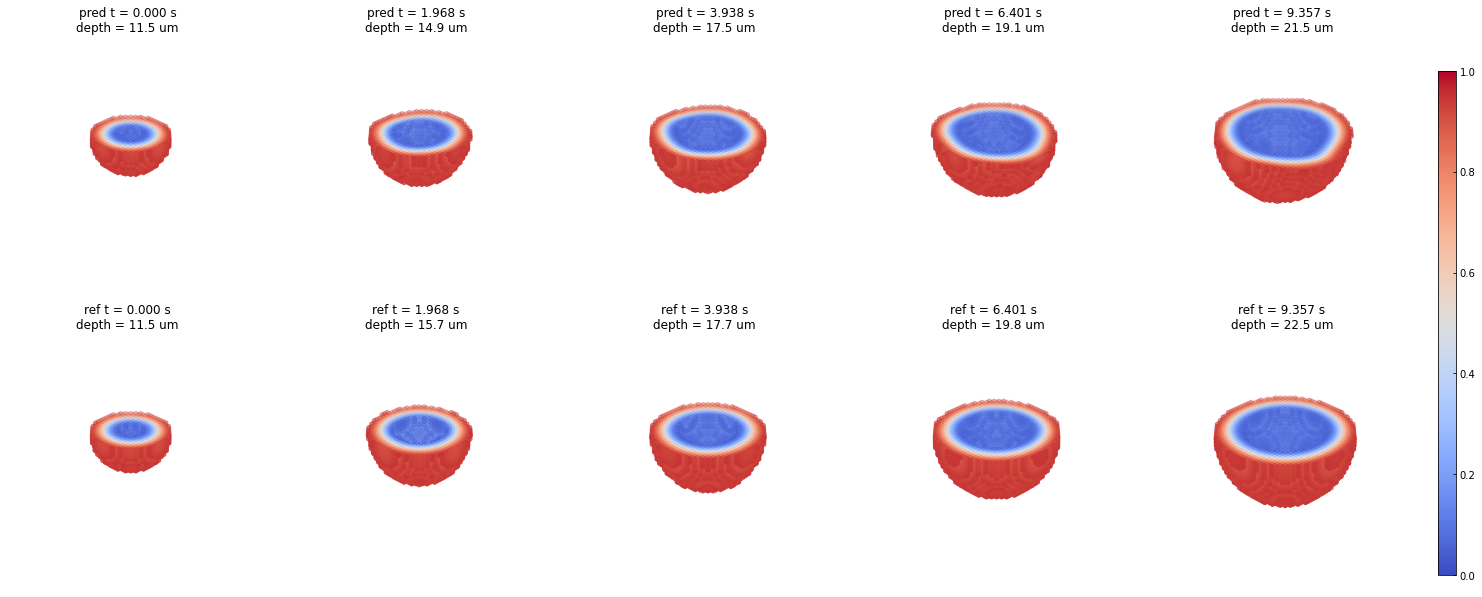

In [4]:
ts = [0.000, 1.968, 3.938, 6.401, 9.357]

mesh_points = np.load("./data/3d/mesh_points.npy") * 1e4
mse = 0

filter_ = np.where(
            (mesh_points[:, 0] >= -0.4) &
            (mesh_points[:, 0] <= 0.4) &
            (mesh_points[:, 1] >= -0.4) &
            (mesh_points[:, 1] <= 0.4) &
            (mesh_points[:, 2] >= 0) &
            (mesh_points[:, 2] <= 0.4)
        )[0]
mesh_points = mesh_points[filter_]

fig, axes = plt.subplots(2, len(ts), figsize=(5*len(ts), 10), 
                                 subplot_kw={"projection": "3d",
                                             "aspect": "auto",
                                             "box_aspect": (1, 1, 0.5),})
mesh_tensor = torch.from_numpy(mesh_points).float()
diffs = []
for idx, tic in enumerate(ts):
    tic_tensor = torch.ones(mesh_tensor.shape[0], 1)\
                .view(-1, 1) * tic * 1e-1
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net.net_u(geotime).detach().cpu().numpy()
        
    ax = axes[0, idx]
    idx_interface_sol = np.where((sol[:, 0] > 0.05) & (sol[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_sol, 0], mesh_points[idx_interface_sol, 1],
                mesh_points[idx_interface_sol, 2], c=sol[idx_interface_sol, 0],
                cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_sol, 0]**2 \
        + mesh_points[idx_interface_sol, 1]**2 \
        + mesh_points[idx_interface_sol, 2]**2) ** 0.5
    )
    ax.set_title(f"pred t = {tic:.3f} s\ndepth = {avg_depth*100:.1f} um\n")
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.))
    
    ax = axes[1, idx]
    truth = np.load("./data/3d/sol-" + f"{tic:.3f}" + ".npy")[filter_]
    diff = np.abs(sol[:, 0] - truth[:, 0])
    diffs.append(diff)
    idx_interface_truth = np.where((truth[:, 0] > 0.05) & (truth[:, 0] < 0.95))[0]
    ax.scatter(mesh_points[idx_interface_truth, 0], mesh_points[idx_interface_truth, 1],
                    mesh_points[idx_interface_truth, 2], c=truth[idx_interface_truth, 0],
                    cmap="coolwarm", label="phi", vmin=0, vmax=1)
    avg_depth = np.mean(
        (mesh_points[idx_interface_truth, 0]**2 \
        + mesh_points[idx_interface_truth, 1]**2 \
        + mesh_points[idx_interface_truth, 2]**2) ** 0.5
    )
    ax.set_title(f"ref t = {tic:.3f} s\ndepth = {avg_depth*100:.1f} um\n")
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set(xlim=(-0.3, 0.3), ylim=(-0.3, 0.3), zlim=(0.3, 0.))
    
# add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax)

diffs = np.array(diffs)
print(f"max diff = {np.max(diffs):.3e}")
print(f"mean diff = {np.mean(diffs):.3e}")